# Import relevant libraries and load dataset

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Conv2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [2]:
# generate batches of tensor image data with real-time data augmentation

datagen = ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory(
"/kaggle/input/kermany2018/OCT2017 /train",
target_size = (224, 224),
batch_size = 128,
class_mode = "categorical",
subset = "training")

validation_generator = datagen.flow_from_directory(
"/kaggle/input/kermany2018/OCT2017 /train",
target_size = (224, 224),
batch_size = 128,
class_mode = "categorical",
subset = "validation")

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


In [3]:
vgg16_model = VGG16(include_top=False, weights="imagenet", pooling=None,input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [4]:
for layer in vgg16_model.layers:
    layer.trainable = False

In [5]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# Flatten Layer
flatten = Flatten()(vgg16_model.output)

# Dense Layer
Dense1 = Dense(256, activation="relu")(flatten)

# Batch Normalization
BatchNormalization = BatchNormalization()(Dense1)

# Dropout Layer
dropout = Dropout(rate=0.5)(BatchNormalization)

# Dense Layer
Dense2 = Dense(128, activation="relu")(dropout)

# Dropout Layer
dropout = Dropout(rate=0.5)(Dense2)

# Dense Layer
Dense3 = Dense(16, activation="relu")(dropout)

# Dense Layer
Output_Layer = Dense(4, activation="softmax")(Dense3)

# Creating a model
model3 = Model(inputs=vgg16_model.input,outputs=Output_Layer)

In [7]:
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1)

# Creating model3_with_augmentation_save folder before running the code.
filepath="vgg_16_model4_with_augmentation_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')

# Callbacks
optimizer = tf.keras.optimizers.Adam()
model3.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

# Creating a list with all the callbacks we want
callback_list = [earlystop, checkpoint]

train_samples = 66788
validation_samples = 16696
batch_size = 128
model3.fit(train_generator, validation_data= validation_generator, steps_per_epoch=train_samples//batch_size, callbacks=callback_list, epochs=50)

Epoch 1/50
521/521 [==============================] - ETA: 0s - loss: 0.5961 - accuracy: 0.7869
Epoch 1: val_accuracy improved from -inf to 0.86943, saving model to vgg_16_model4_with_augmentation_save/weights-01-0.8694.hdf5
521/521 [==============================] - 1647s 3s/step - loss: 0.5961 - accuracy: 0.7869 - val_loss: 0.3673 - val_accuracy: 0.8694
Epoch 2/50
521/521 [==============================] - ETA: 0s - loss: 0.4112 - accuracy: 0.8526
Epoch 2: val_accuracy improved from 0.86943 to 0.87913, saving model to vgg_16_model4_with_augmentation_save/weights-02-0.8791.hdf5
521/521 [==============================] - 1234s 2s/step - loss: 0.4112 - accuracy: 0.8526 - val_loss: 0.3494 - val_accuracy: 0.8791
Epoch 3/50
521/521 [==============================] - ETA: 0s - loss: 0.3759 - accuracy: 0.8664
Epoch 3: val_accuracy did not improve from 0.87913
521/521 [==============================] - 1239s 2s/step - loss: 0.3759 - accuracy: 0.8664 - val_loss: 0.3415 - val_accuracy: 0.8754
E

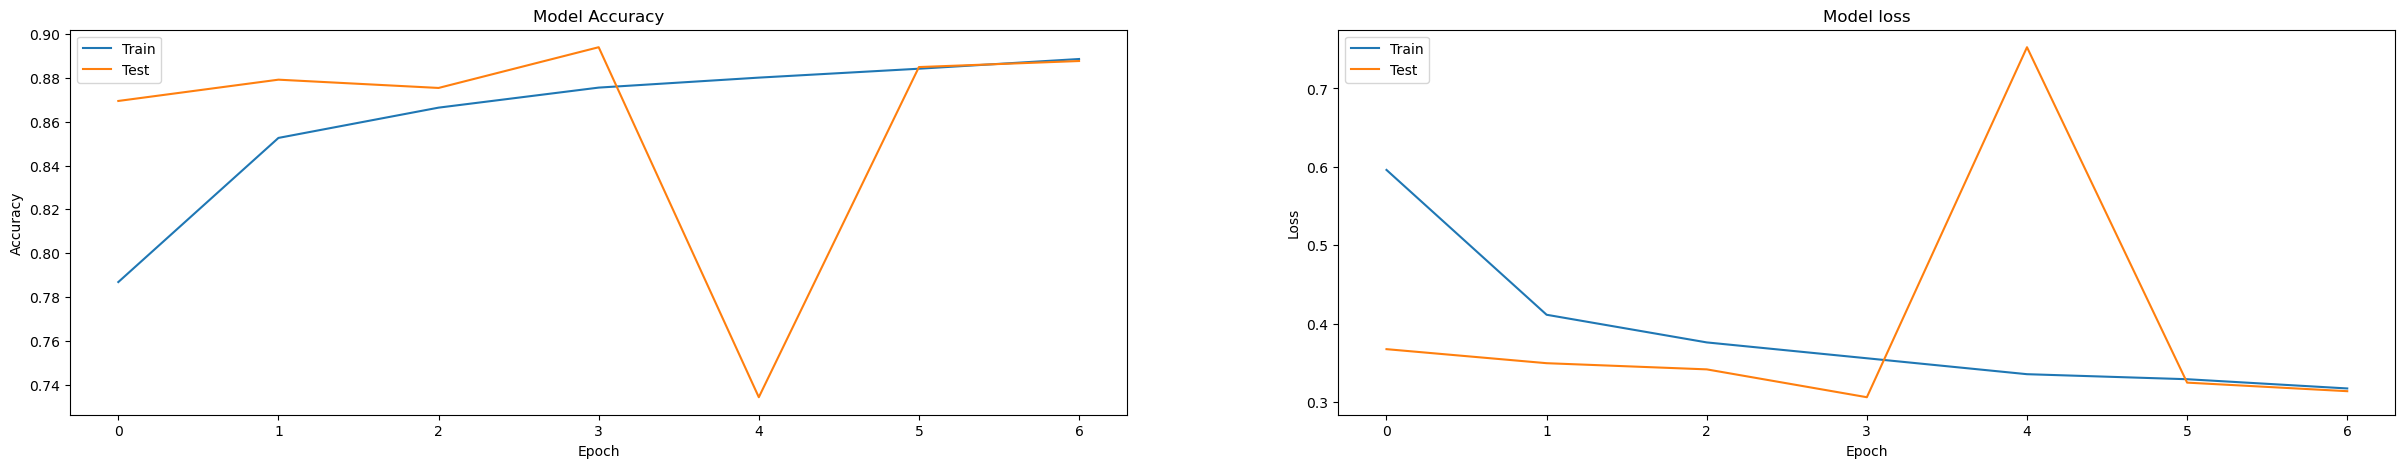

In [9]:
# Plot training & validation acc values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model3.history.history['accuracy'])
plt.plot(model3.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model3.history.history['loss'])
plt.plot(model3.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
# Accuracy on test dataset

test_generator = datagen.flow_from_directory(
    "/kaggle/input/kermany2018/OCT2017 /test",
    target_size = (224, 224),
    batch_size=128,
    class_mode = "categorical",
    shuffle = False)
test_samples = 968
batch_size = 128

result = model3.evaluate(test_generator, steps = test_samples // batch_size+1, verbose = 1)
print("Accuracy on Test Dataset:{0}, Loss on Test Dataset: {1}".format(result[1]*100,result[0]))

Found 968 images belonging to 4 classes.
8/8 [==============================] - 23s 3s/step - loss: 0.2463 - accuracy: 0.9039
Accuracy on Test Dataset:90.39255976676941, Loss on Test Dataset: 0.2462962567806244


8/8 [==============================] - 14s 2s/step


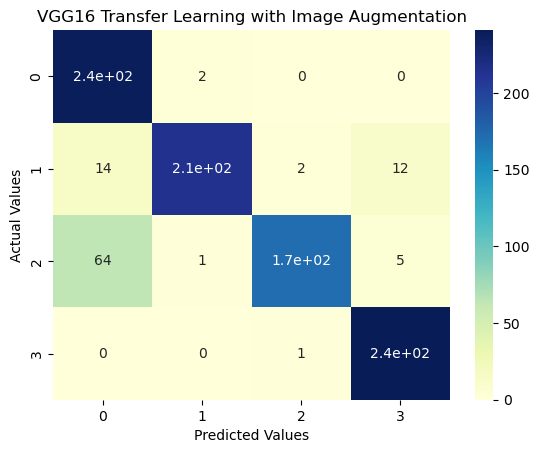

In [11]:
# predicted values
y_pred = model3.predict(test_generator, test_samples // batch_size+1)
predicted_values = np.argmax(y_pred, axis=1)

confusionmatrix = confusion_matrix(test_generator.classes,predicted_values)
plt.title("VGG16 Transfer Learning with Image Augmentation")
sns.heatmap(confusionmatrix, annot=True, cmap="YlGnBu")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()